<a href="https://colab.research.google.com/github/Matheus2608/Data-Science/blob/main/Projeto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fazendo segmentação de instâncias de doenças em morangos

## Importando dataset do Kaggle de imagens de morangos com doenças
Para isso, eu fiz o download por linha de comando pelo dataset ser pesado. De referência segui os passos desse site: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

Mas para isso é necessário ter uma conta no kaggle, se você não tiver sugiro que entre no link que estou fazendo o download do dataset e faça o download pra sua máquina e depois transfira para o Colab

In [ ]:
!pip install opendatasets
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset")

Skipping, found downloaded files in "./strawberry-disease-detection-dataset" (use force=True to force download)


## Treinando Yolact ++
## Setup Inicial
- Para utilizar esse modelo, é necessário importar algumas bibliotecas antes


In [ ]:
# Cython precisa ser instalado antes de pycocotools
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

#DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0

## Importando o código da Yolact do github dos autores dela

In [ ]:
# Clone the repo
!git clone https://github.com/dbolya/yolact.git

## DCNv2
É necessário contruir essa biblioteca, **mas** para isso é necessário que o colab esteja rodando no modo GPU

Para isso:
- Clique em Editar > COnfigurações de Notebook
- Coloque GPU como seu hardware e salve


In [ ]:
%cd /content/yolact/external/DCNv2
!python setup.py build develop

## Pesos
- Para não demorar muito o treinamento, vou usar pesos de outro modelo ja treinado
- Tentei de quase todos jeitos possíveis usando comando, mas o yolact não funciona.
- É necessário baixar o peso no github e exportar para esse colab

In [ ]:
%cd /content/yolact
%mkdir weights

In [ ]:
!gdown "https://drive.google.com/uc?id=15id0Qq5eqRbkD-N3ZjDZXdCvRyIaHpFB&export=download" -O "./weights/yolact_plus_base_54_800000.pth"

## Formatando a base de dados

In [ ]:
!pip install -U labelme2coco

In [9]:
%cd /content/yolact/data/

# import functions
from labelme2coco import get_coco_from_labelme_folder, save_json

# set labelme training data directory
labelme_train_folder = "/content/strawberry-disease-detection-dataset/train/"

# set labelme validation data directory
labelme_val_folder = "/content/strawberry-disease-detection-dataset/val/"

# set path for coco json to be saved
export_dir = "/content/"

# create train coco object
train_coco = get_coco_from_labelme_folder(labelme_train_folder)

# export train coco json
save_json(train_coco.json, export_dir+"train.json")

# create val coco object
val_coco = get_coco_from_labelme_folder(labelme_val_folder, coco_category_list=train_coco.json_categories)

# export val coco json
save_json(val_coco.json, export_dir+"val.json")

/content/yolact/data
There are 1450 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 1450/1450 [00:08<00:00, 176.99it/s]


There are 307 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 307/307 [00:01<00:00, 242.97it/s]


In [ ]:
# Fazendo diretório para as imagens
%cd /content/
%mkdir train_images valid_images test_images

#Transferindo as imagens dentro do dataset para o direotrio root
%cd /content/strawberry-disease-detection-dataset/train
%mv *.jpg ../../train_images/
%cd ../val/
%mv *.jpg ../../valid_images/
%cd ../test
%mv *.jpg ../../test_images/

## Agora que o dataset está formatado do jeito que é necessário, é preciso mudar o arquivo config.py eyolact.py


In [ ]:
'''
# ----------------------- DATASETS ----------------------- #
...

my_custom_dataset = dataset_base.copy({
    'name': 'Doença de Morango',

    'train_images': '/content/train_images',
    'train_info':   '/content/train.json',

    'valid_images': '/content/valid_images',
    'valid_info':   '/content/val.json',

    'has_gt': True,
    'class_names': ("Powdery Mildew Leaf", "Leaf Spot", "Angular Leafspot", "Powdery Mildew Fruit", "Gray Mold", "Anthracnose Fruit Rot", "Blossom Blight"),
    'label_map': {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}
})

# ----------------------- CONFIG DEFAULTS ----------------------- #

coco_base_config = Config({
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1, # This should include the background class,
    

# ----------------------- YOLACT++ CONFIGS ----------------------- #

yolact_plus_base_config = yolact_base_config.copy({
    'name': 'yolact_plus_base',
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1,
    'backbone': resnet101_dcn_inter3_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),

    'use_maskiou': True,
    'maskiou_net': [(8, 3, {'stride': 2}), (16, 3, {'stride': 2}), (32, 3, {'stride': 2}), (64, 3, {'stride': 2}), (128, 3, {'stride': 2})],
    'maskiou_alpha': 25,
    'rescore_bbox': False,
    'rescore_mask': True,

    'discard_mask_area': 5*5,
})
'''

#no arquivo yolact.py
'''
linha 490
try:
    self.load_state_dict(state_dict)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

linha 631
p = pred_layer(pred_x.detach())

'''



In [12]:
%cd /content/yolact

/content/yolact


In [21]:
#!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_54_800000.pth  --start_iter=0

In [29]:
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_5_910_interrupt.pth --save_folder checkpoint_models --start_iter=-1

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Resuming training, loading weights/yolact_plus_base_5_910_interrupt.pth...
Begin training!

/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentation

In [86]:
!python eval.py --config=yolact_plus_base_config --trained_model=checkpoint_models/yolact_plus_base_9_1632_interrupt.pth  

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model... Done.

Processing Images  ██████████████████████████████    307 /    307 (100.00%)     4.51 fps        
Saving data...
Calculating mAP...

       |  all  |  .50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95  |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
   box | 49.83 | 74.19 | 73.62 | 72.24 | 70.27 | 64.16 | 55.33 | 43.51 | 27.77 | 13.80 |  3.36 |
  mask | 46.73 | 64.61 | 62.48 | 61.42 | 60.34 | 58.73 | 54.66 | 48.87 | 36.52 | 16.96 |  2.75 |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+



In [ ]:
!python eval.py --config=yolact_plus_base_config --trained_model=checkpoint_models/yolact_plus_base_9_1632_interrupt.pth --images=../valid_images:../output_valid_images --score_threshold=0.2 --top_k=20

/content/output_valid_images


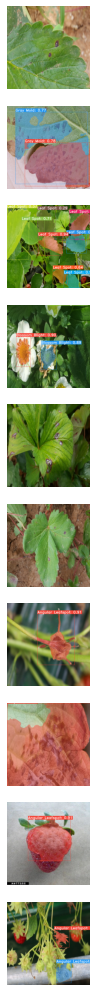

In [89]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(24, 18))
%cd /content/output_valid_images/
fotos = os.listdir()

cont = 0
for foto in fotos:
  if cont == 10:
    break
  ax = plt.subplot(10, 1, cont + 1)
  img = mpimg.imread(foto)
  plt.imshow(img)
  plt.axis('off') 
  cont += 1
plt.show()

## Yolact++
@article{yolact-plus-tpami2020,

  author  = {Daniel Bolya and Chong Zhou and Fanyi Xiao and Yong Jae Lee},

  journal = {IEEE Transactions on Pattern Analysis and Machine Intelligence}, 

  title   = {YOLACT++: Better Real-time Instance Segmentation}, 

  year    = {2020},
  
}

## Dataset
Afzaal, U.; Bhattarai, B.; Pandeya, Y.R.; Lee, J. An Instance Segmentation Model for Strawberry Diseases Based on Mask R-CNN. Sensors 2021, 21, 6565

In [17]:
# %cd /content/
# %rm -rf strawberry-disease-detection-dataset
# %rm -rf yolact
# %rm -rf train.json val.json
# %rm -rf train_images/ valid_images/ view

## Referências:
- https://github.com/dbolya/yolact/issues/334
- https://github.com/dbolya/yolact/issues/36
- https://github.com/dbolya/yolact/issues/58
- https://www.immersivelimit.com/tutorials/yolact-with-google-colab

Mensagem da primeira iteração

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Resuming training, loading weights/yolact_plus_base_54_800000.pth...
Ignoring "Error(s) in loading state_dict for Yolact:
	size mismatch for maskiou_net.maskiou_net.10.weight: copying a param with shape torch.Size([80, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([7, 128, 1, 1]).
	size mismatch for maskiou_net.maskiou_net.10.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for prediction_layers.0.conf_layer.weight: copying a param with shape torch.Size([729, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([72, 256, 3, 3]).
	size mismatch for prediction_layers.0.conf_layer.bias: copying a param with shape torch.Size([729]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for semantic_seg_conv.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([7, 256, 1, 1]).
	size mismatch for semantic_seg_conv.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([7])."
Begin training!

/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
[  0]       0 || B: 2.171 | C: 13.125 | M: 3.424 | S: 4.364 | I: 4.270 | T: 27.354 || ETA: 0:00:00 || timer: 4.759

[  0]      10 || B: 2.125 | C: 10.754 | M: 3.363 | S: 3.453 | I: 4.908 | T: 24.604 || ETA: 13 days, 0:48:17 || timer: 1.402

[  0]      20 || B: 1.945 | C: 9.219 | M: 3.079 | S: 2.632 | I: 4.857 | T: 21.732 || ETA: 13 days, 0:27:20 || timer: 1.398

[  0]      30 || B: 1.874 | C: 8.174 | M: 2.869 | S: 2.246 | I: 4.537 | T: 19.700 || ETA: 13 days, 2:39:33 || timer: 1.446

[  0]      40 || B: 1.827 | C: 7.430 | M: 2.788 | S: 1.977 | I: 4.334 | T: 18.356 || ETA: 13 days, 5:33:41 || timer: 1.455

[  0]      50 || B: 1.781 | C: 6.902 | M: 2.746 | S: 1.761 | I: 4.184 | T: 17.374 || ETA: 13 days, 7:56:11 || timer: 1.489

[  0]      60 || B: 1.712 | C: 6.489 | M: 2.672 | S: 1.643 | I: 4.043 | T: 16.558 || ETA: 13 days, 10:45:51 || timer: 1.525

[  0]      70 || B: 1.663 | C: 6.158 | M: 2.585 | S: 1.533 | I: 3.821 | T: 15.761 || ETA: 13 days, 14:08:25 || timer: 1.565

[  0]      80 || B: 1.645 | C: 5.906 | M: 2.554 | S: 1.455 | I: 3.750 | T: 15.312 || ETA: 13 days, 17:53:35 || timer: 1.616

[  0]      90 || B: 1.601 | C: 5.708 | M: 2.512 | S: 1.393 | I: 3.734 | T: 14.948 || ETA: 13 days, 20:31:32 || timer: 1.594

[  0]     100 || B: 1.572 | C: 5.466 | M: 2.469 | S: 1.309 | I: 3.744 | T: 14.559 || ETA: 13 days, 21:46:55 || timer: 1.566

[  0]     110 || B: 1.483 | C: 4.796 | M: 2.367 | S: 1.048 | I: 3.593 | T: 13.287 || ETA: 13 days, 22:56:52 || timer: 1.573

[  0]     120 || B: 1.429 | C: 4.408 | M: 2.302 | S: 0.941 | I: 3.456 | T: 12.536 || ETA: 14 days, 0:00:53 || timer: 1.576

[  0]     130 || B: 1.364 | C: 4.164 | M: 2.241 | S: 0.882 | I: 3.461 | T: 12.112 || ETA: 14 days, 0:59:51 || timer: 1.566

[  0]     140 || B: 1.308 | C: 4.012 | M: 2.179 | S: 0.826 | I: 3.396 | T: 11.720 || ETA: 14 days, 1:57:34 || timer: 1.608

[  0]     150 || B: 1.268 | C: 3.895 | M: 2.123 | S: 0.803 | I: 3.372 | T: 11.462 || ETA: 14 days, 2:42:08 || timer: 1.583

[  0]     160 || B: 1.237 | C: 3.815 | M: 2.074 | S: 0.762 | I: 3.432 | T: 11.321 || ETA: 14 days, 3:20:57 || timer: 1.539

[  0]     170 || B: 1.221 | C: 3.736 | M: 2.073 | S: 0.754 | I: 3.411 | T: 11.195 || ETA: 14 days, 4:04:20 || timer: 1.587

[  0]     180 || B: 1.180 | C: 3.668 | M: 2.064 | S: 0.716 | I: 3.355 | T: 10.983 || ETA: 14 days, 4:22:12 || timer: 1.561
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
[  1]     190 || B: 1.156 | C: 3.580 | M: 2.033 | S: 0.688 | I: 3.333 | T: 10.790 || ETA: 14 days, 6:27:13 || timer: 1.580

[  1]     200 || B: 1.123 | C: 3.489 | M: 1.997 | S: 0.650 | I: 3.272 | T: 10.531 || ETA: 14 days, 6:39:55 || timer: 1.545

[  1]     210 || B: 1.091 | C: 3.390 | M: 1.919 | S: 0.633 | I: 3.262 | T: 10.296 || ETA: 14 days, 6:58:20 || timer: 1.557

[  1]     220 || B: 1.073 | C: 3.312 | M: 1.878 | S: 0.626 | I: 3.192 | T: 10.081 || ETA: 14 days, 7:23:08 || timer: 1.626

[  1]     230 || B: 1.069 | C: 3.249 | M: 1.891 | S: 0.586 | I: 3.056 | T: 9.851 || ETA: 14 days, 7:33:38 || timer: 1.563

[  1]     240 || B: 1.049 | C: 3.163 | M: 1.876 | S: 0.584 | I: 3.066 | T: 9.737 || ETA: 14 days, 7:41:26 || timer: 1.554

[  1]     250 || B: 1.026 | C: 3.074 | M: 1.850 | S: 0.573 | I: 3.046 | T: 9.569 || ETA: 14 days, 7:41:27 || timer: 1.532

[  1]     260 || B: 1.023 | C: 2.988 | M: 1.846 | S: 0.574 | I: 2.892 | T: 9.324 || ETA: 14 days, 7:48:34 || timer: 1.534

[  1]     270 || B: 0.996 | C: 2.911 | M: 1.809 | S: 0.545 | I: 2.982 | T: 9.244 || ETA: 14 days, 7:58:12 || timer: 1.561

[  1]     280 || B: 0.984 | C: 2.828 | M: 1.767 | S: 0.547 | I: 2.989 | T: 9.115 || ETA: 14 days, 8:04:32 || timer: 1.565

[  1]     290 || B: 1.002 | C: 2.791 | M: 1.769 | S: 0.527 | I: 2.997 | T: 9.086 || ETA: 14 days, 8:11:57 || timer: 1.589

[  1]     300 || B: 1.011 | C: 2.747 | M: 1.774 | S: 0.521 | I: 3.095 | T: 9.147 || ETA: 14 days, 8:18:52 || timer: 1.545

[  1]     310 || B: 1.008 | C: 2.692 | M: 1.761 | S: 0.503 | I: 3.050 | T: 9.015 || ETA: 14 days, 8:26:04 || timer: 1.577

[  1]     320 || B: 0.996 | C: 2.643 | M: 1.750 | S: 0.485 | I: 3.069 | T: 8.943 || ETA: 14 days, 8:32:49 || timer: 1.562

[  1]     330 || B: 0.986 | C: 2.587 | M: 1.709 | S: 0.479 | I: 3.079 | T: 8.840 || ETA: 14 days, 8:44:54 || timer: 1.599

[  1]     340 || B: 0.977 | C: 2.549 | M: 1.680 | S: 0.481 | I: 3.159 | T: 8.846 || ETA: 14 days, 8:51:13 || timer: 1.555

[  1]     350 || B: 0.987 | C: 2.524 | M: 1.685 | S: 0.482 | I: 3.095 | T: 8.772 || ETA: 14 days, 9:00:19 || timer: 1.601

[  1]     360 || B: 0.988 | C: 2.493 | M: 1.692 | S: 0.450 | I: 3.158 | T: 8.781 || ETA: 14 days, 9:03:15 || timer: 1.559
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
[  2]     370 || B: 0.993 | C: 2.458 | M: 1.692 | S: 0.435 | I: 3.102 | T: 8.680 || ETA: 14 days, 10:09:37 || timer: 1.562

[  2]     380 || B: 0.996 | C: 2.434 | M: 1.679 | S: 0.411 | I: 3.207 | T: 8.729 || ETA: 14 days, 10:12:15 || timer: 1.567

[  2]     390 || B: 0.973 | C: 2.364 | M: 1.637 | S: 0.396 | I: 3.169 | T: 8.539 || ETA: 14 days, 10:16:18 || timer: 1.563

[  2]     400 || B: 0.970 | C: 2.317 | M: 1.610 | S: 0.384 | I: 3.031 | T: 8.312 || ETA: 14 days, 10:22:20 || timer: 1.583

[  2]     410 || B: 0.975 | C: 2.320 | M: 1.620 | S: 0.377 | I: 3.080 | T: 8.371 || ETA: 14 days, 10:23:55 || timer: 1.561

[  2]     420 || B: 0.985 | C: 2.297 | M: 1.621 | S: 0.379 | I: 3.073 | T: 8.354 || ETA: 14 days, 10:28:38 || timer: 1.584

[  2]     430 || B: 0.980 | C: 2.271 | M: 1.615 | S: 0.390 | I: 3.096 | T: 8.351 || ETA: 14 days, 10:31:34 || timer: 1.563

[  2]     440 || B: 0.988 | C: 2.230 | M: 1.611 | S: 0.375 | I: 3.038 | T: 8.242 || ETA: 14 days, 10:33:18 || timer: 1.554

[  2]     450 || B: 0.977 | C: 2.207 | M: 1.582 | S: 0.356 | I: 3.094 | T: 8.216 || ETA: 14 days, 10:35:05 || timer: 1.562

[  2]     460 || B: 0.968 | C: 2.188 | M: 1.577 | S: 0.370 | I: 3.091 | T: 8.193 || ETA: 14 days, 10:38:05 || timer: 1.540

[  2]     470 || B: 0.966 | C: 2.183 | M: 1.575 | S: 0.375 | I: 3.168 | T: 8.266 || ETA: 14 days, 10:44:00 || timer: 1.580

[  2]     480 || B: 0.990 | C: 2.186 | M: 1.611 | S: 0.370 | I: 3.119 | T: 8.275 || ETA: 14 days, 10:45:04 || timer: 1.558

[  2]     490 || B: 0.998 | C: 2.177 | M: 1.615 | S: 0.379 | I: 3.041 | T: 8.209 || ETA: 14 days, 10:47:18 || timer: 1.555

[  2]     500 || B: 0.989 | C: 2.171 | M: 1.627 | S: 0.392 | I: 3.004 | T: 8.183 || ETA: 14 days, 10:50:26 || timer: 1.579

[  2]     510 || B: 0.997 | C: 2.140 | M: 1.621 | S: 0.385 | I: 3.001 | T: 8.144 || ETA: 14 days, 10:52:16 || timer: 1.581

[  2]     520 || B: 1.003 | C: 2.146 | M: 1.621 | S: 0.378 | I: 2.992 | T: 8.140 || ETA: 14 days, 10:52:49 || timer: 1.539

[  2]     530 || B: 1.007 | C: 2.147 | M: 1.631 | S: 0.367 | I: 3.006 | T: 8.158 || ETA: 14 days, 10:53:30 || timer: 1.573

[  2]     540 || B: 1.031 | C: 2.170 | M: 1.660 | S: 0.355 | I: 2.921 | T: 8.138 || ETA: 14 days, 10:53:10 || timer: 1.564

Computing validation mAP (this may take a while)...


Calculating mAP...

       |  all  |  .50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95  |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
   box | 41.14 | 69.80 | 67.26 | 63.69 | 60.37 | 53.24 | 42.26 | 31.36 | 15.78 |  5.91 |  1.75 |
  mask | 40.87 | 60.52 | 57.95 | 57.11 | 56.72 | 53.08 | 44.95 | 36.13 | 26.92 | 11.48 |  3.83 |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+

/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
[  3]     550 || B: 1.044 | C: 2.151 | M: 1.657 | S: 0.352 | I: 2.884 | T: 8.087 || ETA: 14 days, 21:33:23 || timer: 1.547

[  3]     560 || B: 1.031 | C: 2.111 | M: 1.624 | S: 0.326 | I: 2.942 | T: 8.035 || ETA: 14 days, 21:24:59 || timer: 1.575

[  3]     570 || B: 1.019 | C: 2.089 | M: 1.587 | S: 0.314 | I: 2.874 | T: 7.882 || ETA: 14 days, 21:13:24 || timer: 1.555

[  3]     580 || B: 0.976 | C: 2.039 | M: 1.512 | S: 0.323 | I: 2.735 | T: 7.585 || ETA: 14 days, 21:04:40 || timer: 1.560

[  3]     590 || B: 0.954 | C: 2.024 | M: 1.515 | S: 0.314 | I: 2.724 | T: 7.531 || ETA: 14 days, 20:54:45 || timer: 1.541

[  3]     600 || B: 0.938 | C: 2.006 | M: 1.481 | S: 0.310 | I: 2.794 | T: 7.528 || ETA: 14 days, 20:47:32 || timer: 1.594

[  3]     610 || B: 0.930 | C: 1.999 | M: 1.465 | S: 0.324 | I: 2.737 | T: 7.456 || ETA: 14 days, 20:38:46 || timer: 1.562

[  3]     620 || B: 0.906 | C: 1.960 | M: 1.446 | S: 0.317 | I: 2.781 | T: 7.409 || ETA: 14 days, 20:30:15 || timer: 1.552

[  3]     630 || B: 0.894 | C: 1.941 | M: 1.416 | S: 0.314 | I: 2.857 | T: 7.422 || ETA: 14 days, 20:21:24 || timer: 1.562

[  3]     640 || B: 0.866 | C: 1.901 | M: 1.392 | S: 0.314 | I: 2.881 | T: 7.354 || ETA: 14 days, 20:14:00 || timer: 1.589

[  3]     650 || B: 0.858 | C: 1.894 | M: 1.398 | S: 0.308 | I: 2.832 | T: 7.290 || ETA: 14 days, 20:05:46 || timer: 1.546

[  3]     660 || B: 0.866 | C: 1.886 | M: 1.399 | S: 0.312 | I: 2.743 | T: 7.205 || ETA: 14 days, 19:59:28 || timer: 1.561

[  3]     670 || B: 0.880 | C: 1.892 | M: 1.419 | S: 0.327 | I: 2.838 | T: 7.356 || ETA: 14 days, 19:51:47 || timer: 1.574

[  3]     680 || B: 0.881 | C: 1.890 | M: 1.423 | S: 0.338 | I: 2.934 | T: 7.466 || ETA: 14 days, 19:41:30 || timer: 1.556

[  3]     690 || B: 0.883 | C: 1.893 | M: 1.403 | S: 0.355 | I: 2.988 | T: 7.521 || ETA: 14 days, 19:32:36 || timer: 1.575

[  3]     700 || B: 0.900 | C: 1.903 | M: 1.426 | S: 0.351 | I: 2.880 | T: 7.459 || ETA: 14 days, 19:27:00 || timer: 1.563

[  3]     710 || B: 0.893 | C: 1.878 | M: 1.423 | S: 0.339 | I: 2.890 | T: 7.424 || ETA: 14 days, 19:19:32 || timer: 1.589

[  3]     720 || B: 0.920 | C: 1.882 | M: 1.443 | S: 0.335 | I: 2.728 | T: 7.307 || ETA: 14 days, 19:12:00 || timer: 1.569
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
[  4]     730 || B: 0.922 | C: 1.873 | M: 1.462 | S: 0.336 | I: 2.528 | T: 7.121 || ETA: 14 days, 19:31:04 || timer: 1.563

[  4]     740 || B: 0.917 | C: 1.862 | M: 1.445 | S: 0.326 | I: 2.392 | T: 6.942 || ETA: 14 days, 19:25:50 || timer: 1.568

[  4]     750 || B: 0.895 | C: 1.843 | M: 1.426 | S: 0.334 | I: 2.569 | T: 7.068 || ETA: 14 days, 19:20:22 || timer: 1.558

[  4]     760 || B: 0.879 | C: 1.848 | M: 1.421 | S: 0.342 | I: 2.551 | T: 7.042 || ETA: 14 days, 19:14:28 || timer: 1.533

[  4]     770 || B: 0.866 | C: 1.836 | M: 1.415 | S: 0.326 | I: 2.501 | T: 6.943 || ETA: 14 days, 19:08:37 || timer: 1.555

[  4]     780 || B: 0.872 | C: 1.829 | M: 1.421 | S: 0.306 | I: 2.441 | T: 6.869 || ETA: 14 days, 19:02:59 || timer: 1.580

[  4]     790 || B: 0.873 | C: 1.823 | M: 1.432 | S: 0.303 | I: 2.409 | T: 6.840 || ETA: 14 days, 18:57:02 || timer: 1.557

[  4]     800 || B: 0.870 | C: 1.810 | M: 1.417 | S: 0.298 | I: 2.474 | T: 6.870 || ETA: 14 days, 18:51:44 || timer: 1.564

[  4]     810 || B: 0.869 | C: 1.827 | M: 1.425 | S: 0.297 | I: 2.497 | T: 6.914 || ETA: 14 days, 18:46:03 || timer: 1.590

[  4]     820 || B: 0.837 | C: 1.809 | M: 1.391 | S: 0.304 | I: 2.593 | T: 6.934 || ETA: 14 days, 18:39:30 || timer: 1.556

[  4]     830 || B: 0.848 | C: 1.792 | M: 1.390 | S: 0.288 | I: 2.622 | T: 6.939 || ETA: 14 days, 18:33:51 || timer: 1.563

[  4]     840 || B: 0.855 | C: 1.800 | M: 1.399 | S: 0.295 | I: 2.830 | T: 7.179 || ETA: 14 days, 18:29:40 || timer: 1.582

[  4]     850 || B: 0.848 | C: 1.778 | M: 1.385 | S: 0.286 | I: 2.702 | T: 7.000 || ETA: 14 days, 18:25:49 || timer: 1.603

[  4]     860 || B: 0.862 | C: 1.781 | M: 1.378 | S: 0.281 | I: 2.752 | T: 7.053 || ETA: 14 days, 18:20:04 || timer: 1.567

[  4]     870 || B: 0.849 | C: 1.733 | M: 1.364 | S: 0.275 | I: 2.579 | T: 6.800 || ETA: 14 days, 18:15:12 || timer: 1.566

[  4]     880 || B: 0.834 | C: 1.707 | M: 1.336 | S: 0.271 | I: 2.551 | T: 6.700 || ETA: 14 days, 18:11:54 || timer: 1.570

[  4]     890 || B: 0.850 | C: 1.697 | M: 1.328 | S: 0.253 | I: 2.608 | T: 6.735 || ETA: 14 days, 18:07:34 || timer: 1.563

[  4]     900 || B: 0.824 | C: 1.678 | M: 1.321 | S: 0.250 | I: 2.663 | T: 6.736 || ETA: 14 days, 18:02:00 || timer: 1.541

Computing validation mAP (this may take a while)...


Calculating mAP...

       |  all  |  .50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95  |
   box | 48.37 | 79.80 | 79.68 | 74.48 | 68.44 | 63.92 | 50.64 | 36.19 | 20.06 |  8.84 |  1.66 |

  mask | 50.13 | 68.89 | 67.87 | 66.90 | 63.66 | 61.51 | 57.52 | 50.55 | 40.07 | 17.68 |  6.67 |

/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
/content/yolact/utils/augmentations.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Stopping early. Saving network...